In [1]:
import numpy as np
import pandas as pd
import matplotlib.gridspec as gsp
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))  


# Import simulation data

In [2]:
df=pd.read_csv('test_final_code_df.csv')
df_results=pd.read_csv('results_simulation_final_code.csv')
df=pd.concat([df, df_results], axis=1)

In [3]:
df.head()

,A_Protein,B_Protein,Noise,Mean,variance,Ni_unknown,reliable_amount_of_cells_unknown,Mixture_number_unknown,Estimation_mixture_number,Discrepancy_ratio,...,mu_MLE,sigma_squared_MLE,mu_std,sigma_squared_std,a_MOM,b_MOM,mu_MOM,sigma_squared_MOM,Inference_grade,Score
0,4.935,3.401,0.202634,16.783935,57.082163,968,1,966.0,955.514007,-0.012899,...,16.780913,55.968126,0.030794,0.146925,3.086187,6.595165,20.353909,1.342374e+02,1.0,0.000000
1,6.020,3.514,0.166113,21.154280,74.336140,998,1,995.0,993.419309,-0.004590,...,21.005750,70.696975,0.038827,0.193413,4.254440,6.054254,25.757461,1.559422e+02,1.0,0.000000
2,7.660,353.058,0.130548,2704.424280,954818.627448,993,1,991.0,983.646900,-0.009419,...,2714.726142,980083.560701,13.613480,165.346173,3.131186,1013.391548,3173.117157,3.215610e+06,1.0,0.196027
3,7.115,10.637,0.140548,75.682255,805.032146,1005,1,1003.0,1015.664167,0.010611,...,75.541458,781.649842,0.154874,1.444689,6.181010,14.561237,90.003151,1.310557e+03,1.0,0.000000
4,6.770,1.931,0.147710,13.072870,25.243712,951,1,949.0,943.144938,-0.008260,...,13.042364,24.958127,0.023298,0.040672,3.256214,4.641158,15.112603,7.013998e+01,1.0,0.000000


# Visualise data

Let's plot the estimates of μ and σ and the ground truth for the two inference procedures

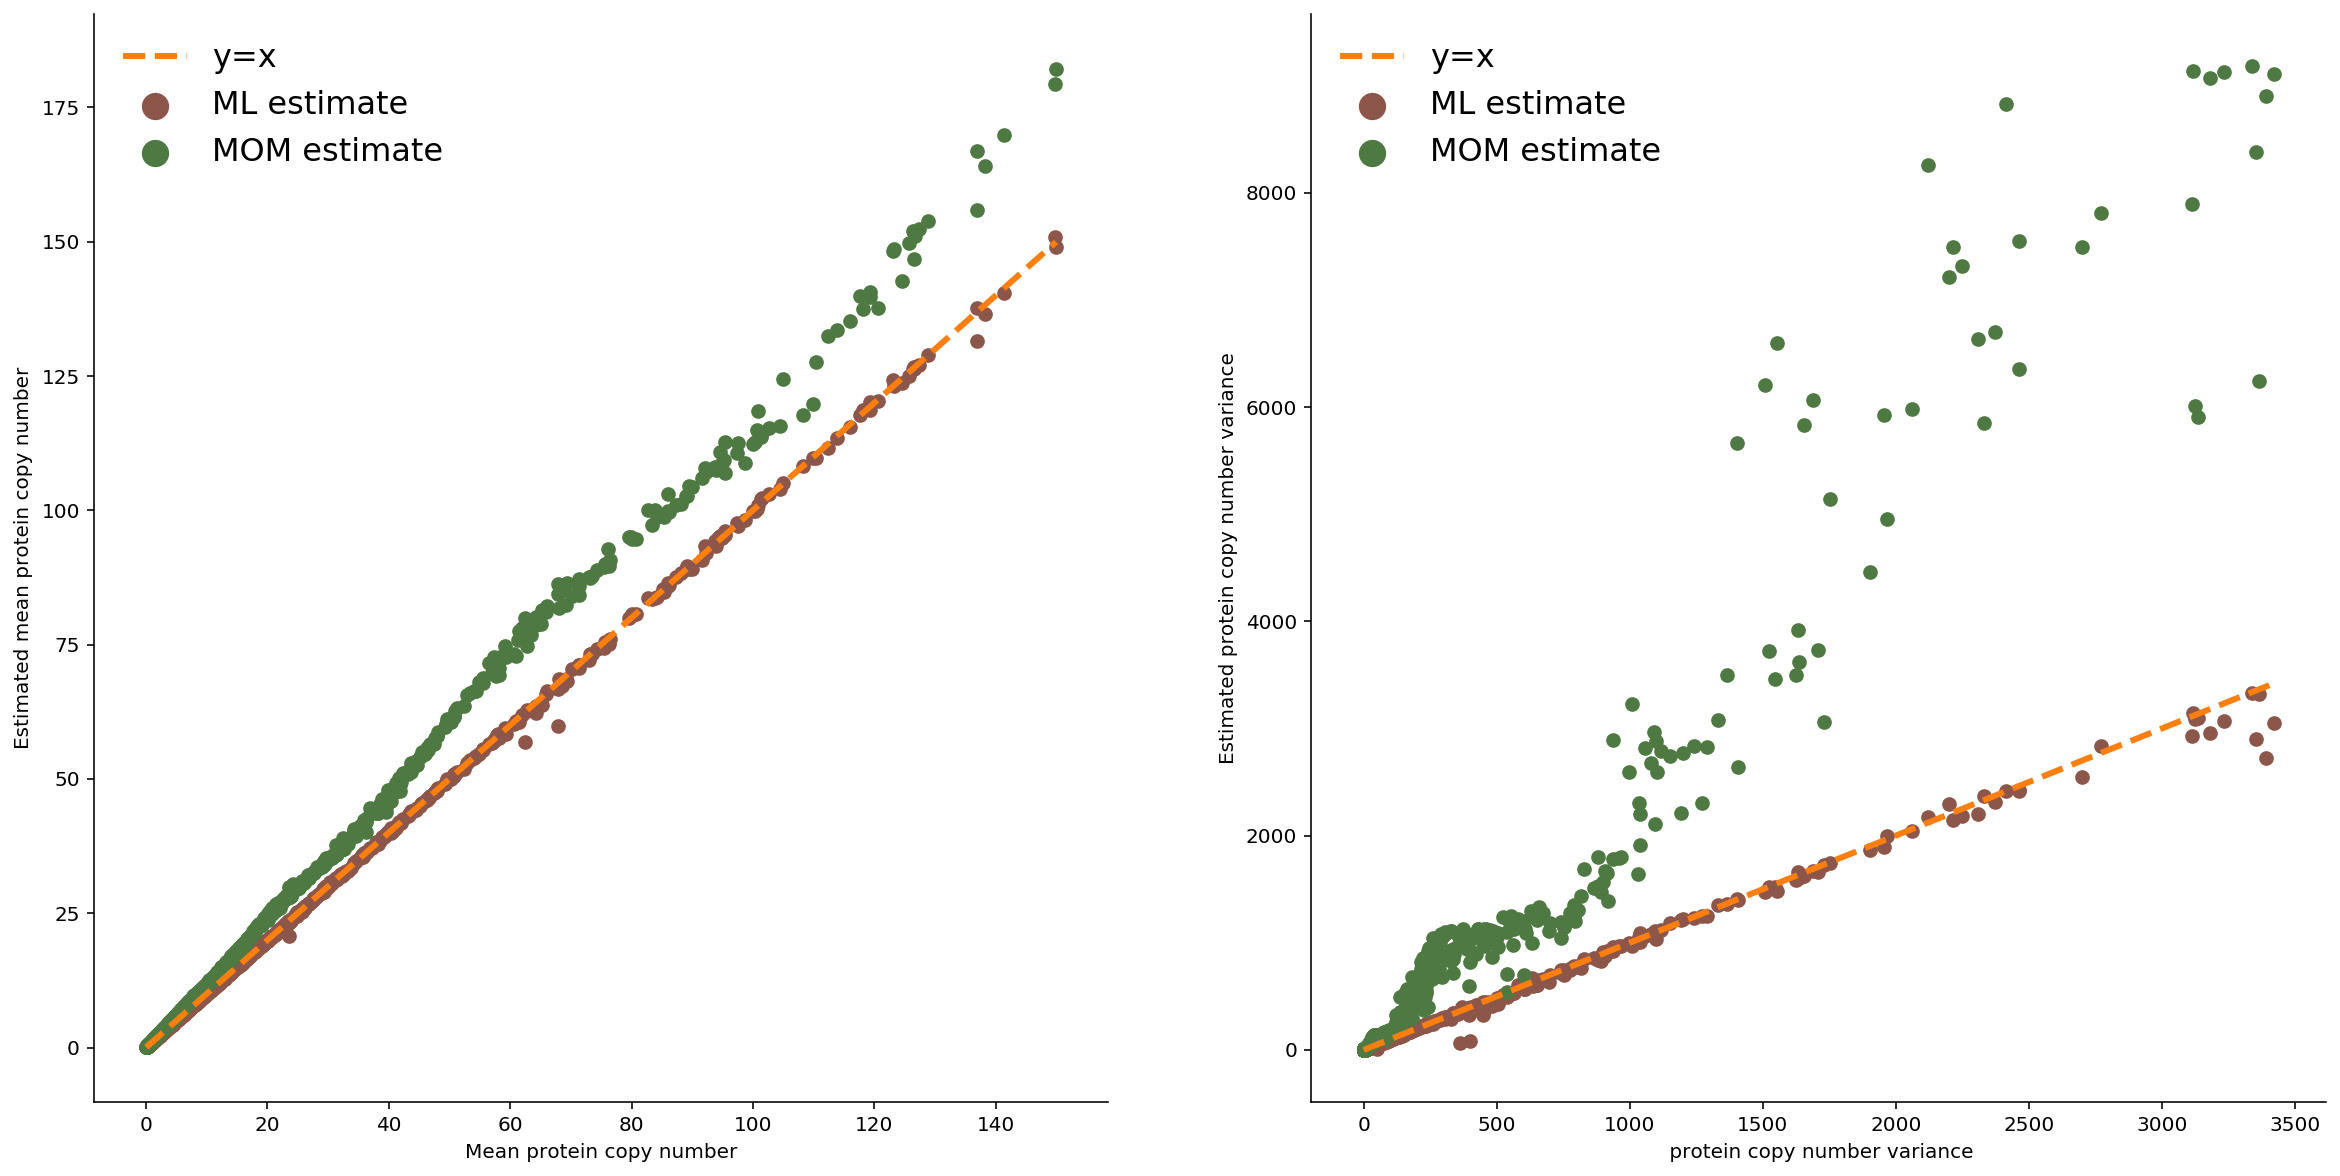

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
df.drop(df.index[[76,671]],inplace=True)

X_mu=df.sort_values('Mean',ascending=True)['Mean'][:898]
Y_mu=df.sort_values('Mean',ascending=True)['mu_MLE'][:898]
Z_mu=df.sort_values('Mean',ascending=True)['mu_MOM'][:898]
X_sigma=df.sort_values('variance',ascending=True)['variance'][:898]
Y_sigma=df.sort_values('variance',ascending=True)['sigma_squared_MLE'][:898]
Z_sigma=df.sort_values('variance',ascending=True)['sigma_squared_MOM'][:898]

ax1.scatter(X_mu,Y_mu,s=40,c='tab:brown',label='ML estimate')
ax1.scatter(X_mu,Z_mu,s=40,c='#4f7942',label='MOM estimate')
ax1.plot(X_mu,X_mu,c='tab:orange',label='y=x',linewidth=3,linestyle='dashed')
ax1.legend()
ax1.set(xlabel='Mean protein copy number', ylabel='Estimated mean protein copy number')
#plt.title('')
ax1.legend(frameon=False,fontsize=16,markerscale=2)

ax2.scatter(X_sigma,Y_sigma,s=40,c='tab:brown',label='ML estimate')
ax2.scatter(X_sigma,Z_sigma,s=40,c='#4f7942',label='MOM estimate')
ax2.plot(X_sigma,X_sigma,c='tab:orange',label='y=x',linewidth=3,linestyle='dashed')
ax2.legend()
ax2.set(xlabel=' protein copy number variance', ylabel='Estimated protein copy number variance')
ax2.legend(frameon=False,fontsize=16,markerscale=2)

sns.despine()

# Compute MAPE criterion

- First, select constructs with enough reads, a big enough sample size, and reasonable inference grade

In [5]:
df['mu_relative_error_MLE']=df.apply(lambda row: np.abs(row['mu_MLE']-row['Mean'])/row['Mean'] 
                                                      if   row['reliable_amount_of_cells_unknown']==1 and row['Inference_grade']<2 else 0  , axis=1)
df['sigma_squared_relative_error_MLE']=df.apply(lambda row: np.abs(row['sigma_squared_MLE']-row['variance'])/row['variance'] 
                                                  if   row['reliable_amount_of_cells_unknown']==1 and row['Inference_grade']<2  else 0     , axis=1)
df['mu_relative_error_MOM']=df.apply(lambda row: np.abs(row['mu_MOM']-row['Mean'])/row['Mean'] 
                                                      if   row['reliable_amount_of_cells_unknown']==1 and row['Inference_grade']<2 else 0  , axis=1)
df['sigma_squared_relative_error_MOM']=df.apply(lambda row: np.abs(row['sigma_squared_MOM']-row['variance'])/row['variance'] 
                                                  if   row['reliable_amount_of_cells_unknown']==1 and row['Inference_grade']<2  else 0     , axis=1)

In [6]:
N_selected=df['mu_relative_error_MLE'].astype(bool).sum(axis=0)
MAPE_mu_ML=100*df['mu_relative_error_MLE'].sum()/N_selected
MAPE_mu_MOM=100*df['mu_relative_error_MOM'].sum()/N_selected
MAPE_sigma_squared_ML=100*df['sigma_squared_relative_error_MLE'].sum()/N_selected
MAPE_sigma_squared_MOM=100*df['sigma_squared_relative_error_MOM'].sum()/N_selected
print(N_selected,MAPE_mu_ML,MAPE_mu_MOM,MAPE_sigma_squared_ML,MAPE_sigma_squared_MOM)

1012 0.8167630574007195 19.778258487530305 3.389717958637286 108.08851944090564
